In [6]:
import pandas as pd
import numpy as np
import jieba,re,os
import jieba.posseg as pseg
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\13051\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
train_data = pd.read_csv('./liar_dataset/train.tsv', sep='\t', encoding='ISO-8859-1',names = ["id", "label", "statement", "subject", "speaker", "job", "state", "party",
                                            "barely-true", "false", "half-true", "mostly-true", "pants-fire", "venue"])

In [9]:
label_dict = {"pants-fire" : 0, "false" : 1, "barely-true" : 2, "half-true" : 3, "mostly-true" : 4, "true" : 5}
print(label_dict)
train_data['output'] = train_data['label'].apply(lambda x: label_dict[x])
train_data.head()

{'pants-fire': 0, 'false': 1, 'barely-true': 2, 'half-true': 3, 'mostly-true': 4, 'true': 5}


,id,label,statement,subject,speaker,job,state,party,barely-true,false,half-true,mostly-true,pants-fire,venue,output
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,1
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,3
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,4
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,1
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,3


In [10]:
col = ['label','statement','output']
train_data = train_data[col]
train_data.head()

,label,statement,output
0,false,Says the Annies List political group supports ...,1
1,half-true,When did the decline of coal start? It started...,3
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",4
3,false,Health care reform legislation is likely to ma...,1
4,half-true,The economic turnaround started at the end of ...,3


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(train_data.statement).toarray()
labels = train_data.output
features.shape

(10240, 4635)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(train_data['statement'], train_data['label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

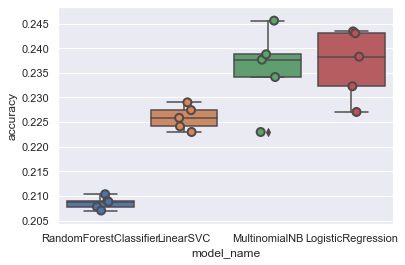

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [14]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.225878
LogisticRegression        0.236813
MultinomialNB             0.235836
RandomForestClassifier    0.208594
Name: accuracy, dtype: float64

E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


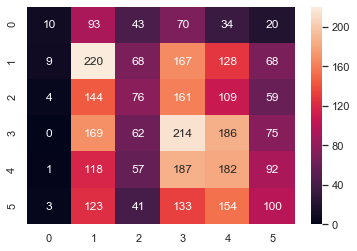

In [24]:
# 使用混淆矩阵查看预测分布情况（LogisticRegression）
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.set()
C2 = confusion_matrix(y_test, y_pred)
sns.heatmap(C2,annot=True,fmt='d')

E:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


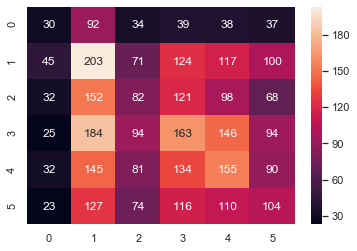

In [25]:
# 使用混淆矩阵查看预测分布情况（RandomForest）
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
model = RandomForestClassifier()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.set()
C2 = confusion_matrix(y_test, y_pred)
sns.heatmap(C2,annot=True,fmt='d')

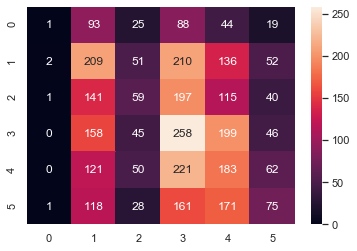

In [27]:
# 使用混淆矩阵查看预测分布情况（MultinomialNB）
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
model = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.set()
C2 = confusion_matrix(y_test, y_pred)
sns.heatmap(C2,annot=True,fmt='d')

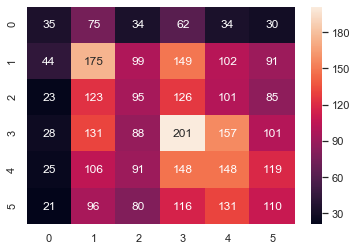

In [28]:
# 使用混淆矩阵查看预测分布情况（LinearSVC）
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.set()
C2 = confusion_matrix(y_test, y_pred)
sns.heatmap(C2,annot=True,fmt='d')

In [26]:
# 多指标评测
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=train_data['label'].unique()))

              precision    recall  f1-score   support

       false       0.16      0.11      0.13       270
   half-true       0.22      0.31      0.26       660
 mostly-true       0.19      0.15      0.17       553
        true       0.23      0.23      0.23       706
 barely-true       0.23      0.24      0.24       637
  pants-fire       0.21      0.19      0.20       554

    accuracy                           0.22      3380
   macro avg       0.21      0.20      0.20      3380
weighted avg       0.21      0.22      0.21      3380

